In [7]:
import os # it provides a way of interacting with the operating system
import numpy as np
import glob # used for finding all the pathnames matching a specified pattern.
import shutil # provide high level interface
import matplotlib.pyplot as plt # used for ploting purpose
import tensorflow as tf 
from tensorflow.keras.models import Sequential #linear stack of layers for building neural network models.
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator # used for data augmentation and preprocessing

In [8]:
URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file(origin=URL,
                                   fname='flower_photos.tgz',
                                   untar=True)
data_dir = os.path.join(os.path.dirname(data_dir), 'flower_photos')

In [9]:
classes = ['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

The flowers dataset directory has this structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
</pre>

The following code will add folders for training and validation data to the existing directory, and move the images there. The original folders will remain, but be empty. In the end, the dataset directory will have this structure:

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>flower_photos</b>
|__ <b>daisy</b>
|__ <b>dandelion</b>
|__ <b>roses</b>
|__ <b>sunflowers</b>
|__ <b>tulips</b>
|__ <b>train</b>
    |______ <b>daisy</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>dandelion</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>roses</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>sunflowers</b>: [1.jpg, 2.jpg, 3.jpg ....]
    |______ <b>tulips</b>: [1.jpg, 2.jpg, 3.jpg ....]
 |__ <b>val</b>
    |______ <b>daisy</b>: [507.jpg, 508.jpg, 509.jpg ....]
    |______ <b>dandelion</b>: [719.jpg, 720.jpg, 721.jpg ....]
    |______ <b>roses</b>: [514.jpg, 515.jpg, 516.jpg ....]
    |______ <b>sunflowers</b>: [560.jpg, 561.jpg, 562.jpg .....]
    |______ <b>tulips</b>: [640.jpg, 641.jpg, 642.jpg ....]
</pre>


In [10]:
for cl in classes:
  imgs_path = os.path.join(data_dir, cl) #go into dir with name of flower
  imgs = glob.glob(imgs_path + '/*.jpg') #find all pics in that dir 
  print(f"{cl}: {len(imgs)} Images")
  train, val = imgs[:round(len(imgs) * 0.8)], imgs[round(len(imgs) * 0.8):] #80-20 split into train/val datasets

  for t in train:
    if not os.path.exists(os.path.join(data_dir, 'train', cl)): os.makedirs(os.path.join(data_dir, 'train', cl)) 

  for v in val:
    if not os.path.exists(os.path.join(data_dir, 'val', cl)): #similar process for validation data
      os.makedirs(os.path.join(data_dir, 'val', cl)) 
    shutil.move(v, os.path.join(data_dir, 'val', cl))


roses: 641 Images


Error: Destination path 'C:\Users\Lenovo\.keras\datasets\flower_photos\val\roses\6255593451_b8a3aa8f7a_m.jpg' already exists

In [12]:
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

In [13]:
BATCH_SIZE = 100
IMG_SHAPE = 150

In [14]:
def PlotImages(imgs):
  dim = 3 #for a 3x3 of images
  plt.figure(figsize=(10, 10))
  for i in range(dim**2):
    plt.subplot(dim, dim, i+1)
    plt.imshow(imgs[i])

In [15]:
img_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    zoom_range=0.5,
    height_shift_range=0.15,
    width_shift_range=0.15,
    brightness_range=(0.5, 1.5),
    fill_mode='wrap'    
)

train_data_gen = img_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    shuffle=True,
    class_mode='sparse'
)

Found 2935 images belonging to 5 classes.


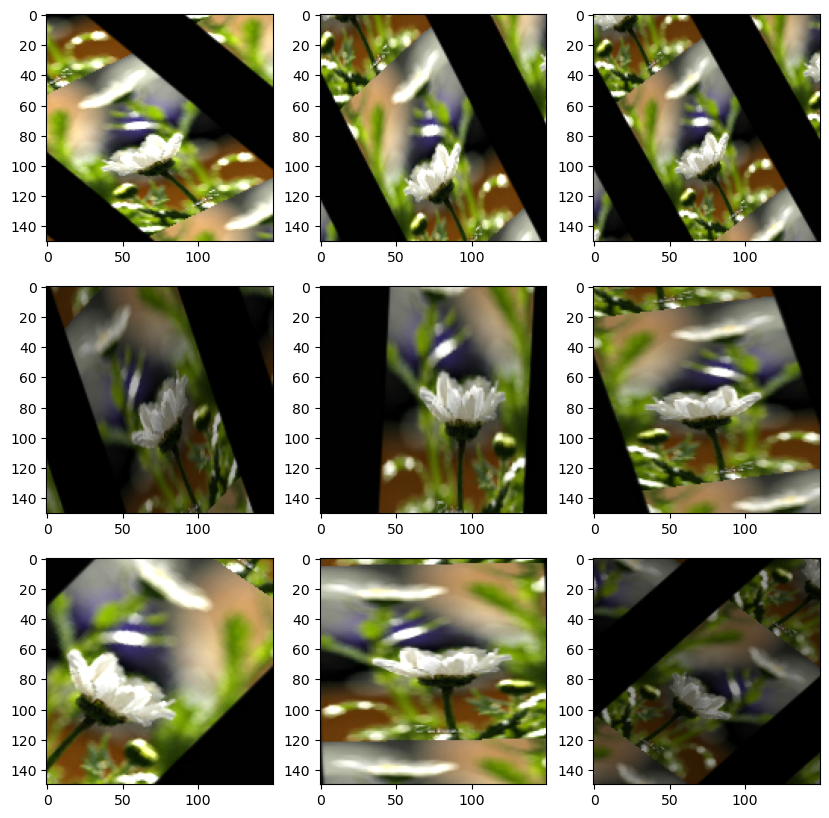

In [16]:
viz_imgs = [train_data_gen[0][0][0] for i in range(9)]
PlotImages(viz_imgs)

In [17]:
img_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = img_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=val_dir,
                                               target_size=(IMG_SHAPE, IMG_SHAPE),
                                               class_mode='sparse')

Found 735 images belonging to 5 classes.


In [18]:
model = Sequential([
   Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
   MaxPooling2D(pool_size=(2,2)),

   Conv2D(32, (3,3), padding='same', activation='relu'),
   MaxPooling2D(pool_size=(2,2)),

   Conv2D(64, (3,3), padding='same', activation='relu'),
   MaxPooling2D(pool_size=(2,2)),

   Flatten(),

   Dropout(0.2),
   Dense(512, activation='relu'),

   Dropout(0.2),
   Dense(5, activation='softmax')                 
])

In [19]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
EPOCHS = 11
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.02)

history = model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(BATCH_SIZE)))
)

Epoch 1/11
30/30 [==============================] - 38s 1s/step - loss: 1.3301 - accuracy: 0.4133 - val_loss: 1.1904 - val_accuracy: 0.5374
Epoch 2/11
30/30 [==============================] - 39s 1s/step - loss: 1.1757 - accuracy: 0.5097 - val_loss: 1.0982 - val_accuracy: 0.5646
Epoch 3/11
30/30 [==============================] - 37s 1s/step - loss: 1.0847 - accuracy: 0.5578 - val_loss: 0.9407 - val_accuracy: 0.6476
Epoch 4/11
30/30 [==============================] - 37s 1s/step - loss: 1.0375 - accuracy: 0.5877 - val_loss: 0.9590 - val_accuracy: 0.6095
Epoch 5/11
30/30 [==============================] - 37s 1s/step - loss: 1.0268 - accuracy: 0.5952 - val_loss: 0.8851 - val_accuracy: 0.6585
Epoch 6/11
30/30 [==============================] - 36s 1s/step - loss: 0.9793 - accuracy: 0.6153 - val_loss: 0.8494 - val_accuracy: 0.6680
Epoch 7/11
30/30 [==============================] - 34s 1s/step - loss: 0.9337 - accuracy: 0.6358 - val_loss: 0.8310 - val_accuracy: 0.6721
Epoch 8/11
30/30 [==

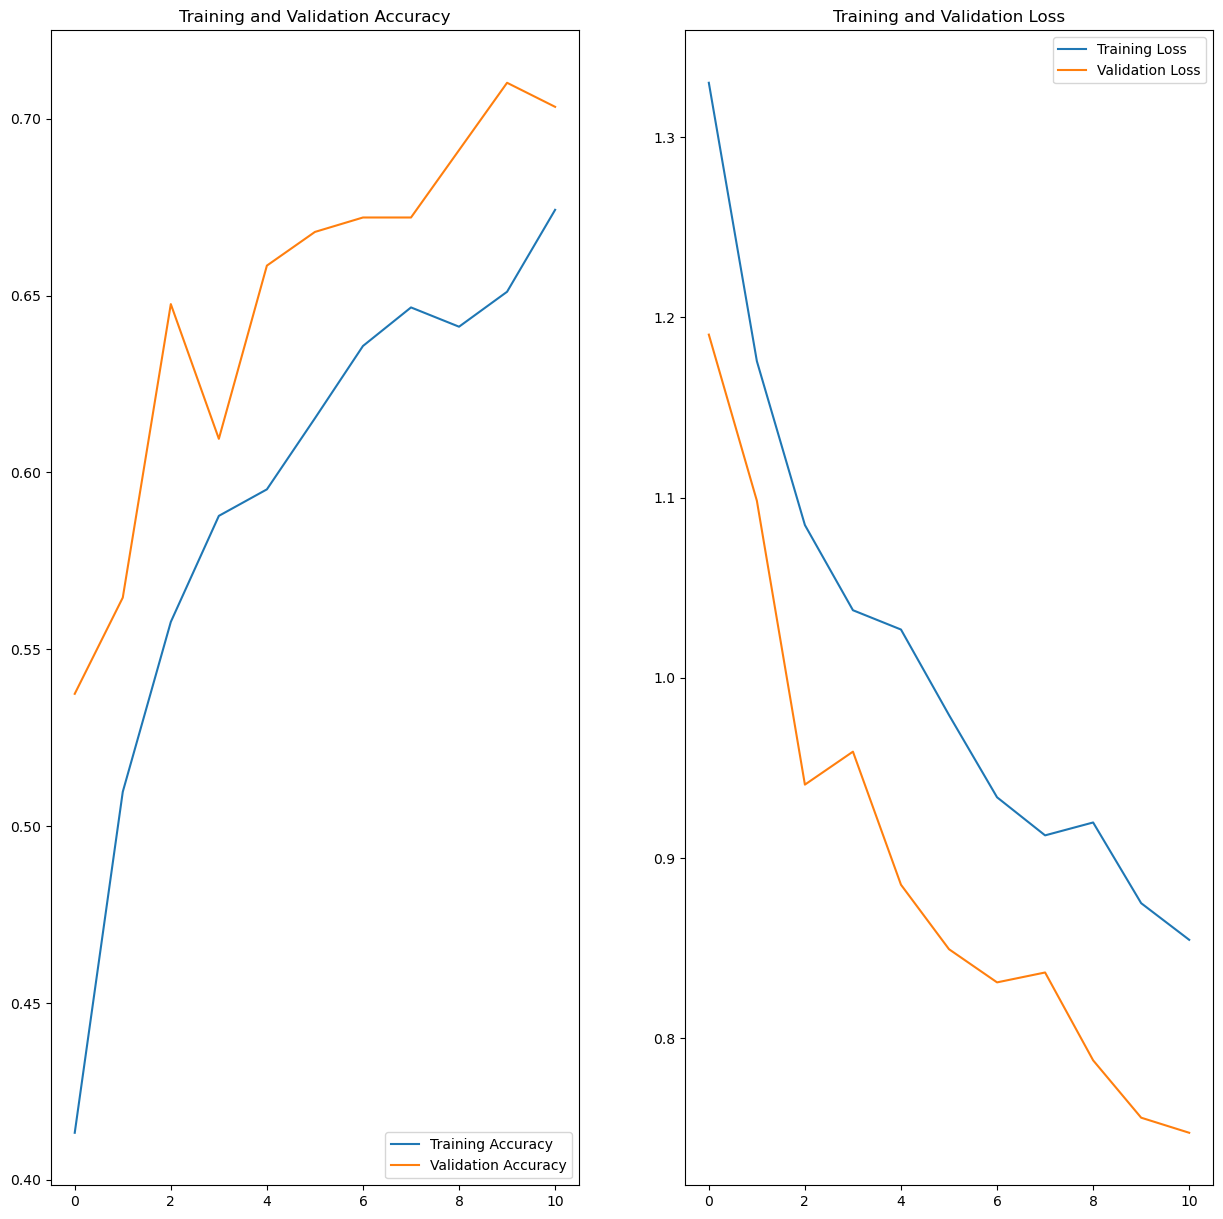

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,15))
x_epochs = range(EPOCHS)

plt.subplot(1, 2, 1)
plt.plot(x_epochs, acc, label='Training Accuracy')
plt.plot(x_epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(x_epochs, loss, label='Training Loss')
plt.plot(x_epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

plt.show()

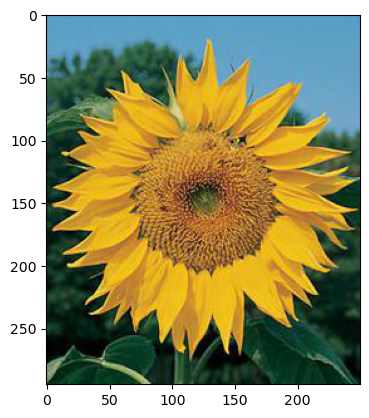

In [29]:
tester = tf.keras.preprocessing.image.load_img('sunflower.jpg')
plt.imshow(tester)

In [30]:
input_arr = tf.keras.preprocessing.image.img_to_array(tester)
input_arr = np.array([input_arr])  # Convert single image to a batch.

resized = tf.image.resize(input_arr, (150, 150))
predictions = model.predict(resized)

guess = predictions.argmax()
print(classes[guess])

1/1 [==============================] - 0s 31ms/step
sunflowers
